# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## **Project 2: An Analysis of Paleo-Present Climate Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests

sns.set_theme()

### **Data Set Components**

1. **Temperature Estimate:**
   - Temperature difference anomaly from the average temperature of the last 1000 years over the past 800,000 years.
   - Temperature estimated from the analysis of deuterium in the ice cores, with various corrections.
     <br>
     <br>

1. **Composite Carbon Dioxide Record:**
   - Composite record of atmospheric carbon dioxide (CO2) levels over the past 800,000 years.
   - Antarctic ice-core records of carbon dioxide extend back 800,000 years at Dome C and over 400,000 years at the Vostok site. Additional shorter recordS from Taylor Dome, another Antarctic location.
     <br>
     <br>

1. **Methane Record (EPICA Dome C Ice Core):**
   - Detailed methane record to 800,000 years before AD 1950.
     <br>
     <br>

1. **Dublin Airport Hourly Data:**
   - Detailed weather data from Dublin airport.
     <br>
     <br>



Composite Rainfall Time Series from 1711-2016 for Ireland
https://www.met.ie/climate/available-data/long-term-data-sets/

IOI_1711_SERIES 

Reconstruction of a long-term historical daily maximum and minimum air temperature network dataset for Ireland (1831-1968)
https://www.met.ie/climate/available-data/long-term-data-sets/

Valentia-Observatory-telegraphic-reporting-station_1921-1943
Valentia-Observatory-telegraphic-reporting-station_1850-1920
Valentia-Observatory_second-order-station_1883-1909


Observatory Monthly Data
https://data.gov.ie/dataset/valentia-observatory-monthly-data
mly2275





### **Antarctic Datasets**

In [2]:
present_year = 1950

Making a full year range as it impossible to use date.time or period on a time period this length. Cannot resample either as it is only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex.

In [3]:
min_year = -850_000
max_year = 2100
year_range = pd.Series(range(min_year, max_year + 1), name="year")

#### **Antarctic Temperature**
Extract temperature data from NOAA EDC3 2007 and convert into a DataFrame.

In [4]:
url = "https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt"
response = requests.get(url)  # Generate response object
text = response.text  # Return the HTML of webpage as string
data = text

# The pattern to find the start of the table
pattern = re.compile(r"Bag\s+ztop\s+Age\s+Deuterium\s+Temperature", re.IGNORECASE)

# Extract the data starting from the match
match = pattern.search(data)
start_index = match.start()
table_data = data[start_index:]

# Convert the table_data to a list of lines
table_lines = table_data.strip().split("\n")

# Extract column names and data
columns = table_lines[0].split()
rows = [line.split() for line in table_lines[1:]]

# Create a Antarctic Temperature DataFrame
antarctic_temp_df = pd.DataFrame(rows, columns=columns)
numeric_columns = ["Bag", "ztop", "Age", "Deuterium", "Temperature"]
antarctic_temp_df[numeric_columns] = antarctic_temp_df[numeric_columns].apply(
    pd.to_numeric, errors="coerce"
)

# Transforming the Antarctic Temperature DataFrame
antarctic_temp_df = antarctic_temp_df.dropna().reset_index(drop=True)
antarctic_temp_df.drop(["Bag", "ztop", "Deuterium"], axis=1, inplace=True)
antarctic_temp_df["year"] = present_year - antarctic_temp_df["Age"].astype(int)
antarctic_temp_df.drop(["Age"], axis=1, inplace=True)
antarctic_temp_df.rename(columns={"Temperature": "temp (°C)"}, inplace=True)
antarctic_temp_df = antarctic_temp_df.drop_duplicates(subset="year")

In [5]:
antarctic_temp_df

,temp (°C),year
0,0.88,1912
1,1.84,1904
2,3.04,1895
3,0.35,1886
4,-0.42,1877
...,...,...
5780,-8.73,-795458
5781,-8.54,-796493
5782,-8.88,-797551
5783,-8.92,-798639


#### **Antarctic Carbon Dioxide**
Extract carbon dioxide data from the Composite CO2 record (0-800 kyr BP) and convert into a DataFrame.

In [6]:
antarctic_carbon_dioxide_df = pd.read_excel(
    "./data/CO2/grl52461-sup-0003-supplementary.xls",
    sheet_name="CO2 Composite",
    skiprows=14,
)

# Transforming the Antarctic CO2 DataFrame
antarctic_carbon_dioxide_df.drop(["sigma mean CO2 (ppmv)"], axis=1, inplace=True)
antarctic_carbon_dioxide_df["year"] = present_year - antarctic_carbon_dioxide_df[
    "Gasage (yr BP) "
].astype(int)
antarctic_carbon_dioxide_df.drop(["Gasage (yr BP) "], axis=1, inplace=True)
antarctic_carbon_dioxide_df = antarctic_carbon_dioxide_df.drop_duplicates(subset="year")

#### **Antarctic Methane**
Extract methane EPICA Dome C Ice Core (0-800 kyr BP) and convert into a DataFrame.

In [7]:
# URL of the data
url = "https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-ch4-2008.txt"

# Fetching the data
response = requests.get(url)
text = response.text

# The pattern to find the start of the table
pattern = re.compile(r"Depth\s+Gas Age\s+CH4 mean\s+1s\s+Lab.", re.IGNORECASE)

# Extract the data starting from the match
match = pattern.search(text)
start_index = match.start()
table_data = text[start_index:]


# Convert the table_data to a list of lines
table_lines = table_data.strip().split("\n")

# Extract column names and data
columns = ["Depth", "Gas Age", "CH4 mean", "1s", "Lab."]
rows = [line.split() for line in table_lines[1:] if line.strip()]

# Create a DataFrame
antarctic_epica_methane_df = pd.DataFrame(rows, columns=columns)
numeric_columns = ["Depth", "Gas Age", "CH4 mean", "1s"]
antarctic_epica_methane_df[numeric_columns] = antarctic_epica_methane_df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Transforming the Antarctic Methane DataFrame
antarctic_epica_methane_df = antarctic_epica_methane_df.dropna().reset_index(drop=True)
antarctic_epica_methane_df.drop(["Depth", "1s", "Lab."], axis=1, inplace=True)
antarctic_epica_methane_df["year"] = present_year - antarctic_epica_methane_df["Gas Age"].astype(int)
antarctic_epica_methane_df.drop(["Gas Age"], axis=1, inplace=True)
antarctic_epica_methane_df.rename(columns={"CH4 mean": "CH4 (ppbv)"}, inplace=True)
antarctic_epica_methane_df = antarctic_epica_methane_df.drop_duplicates(subset="year")

Extract methane and carbon dioxide data from the Law Dome CH4 CO2 0-2000 AD and convert into a DataFrame.

In [8]:
antarctic_law_dome_co2_df = pd.read_excel(
    "./data/CH4/Historic_Greenhouse_gas_concentrations_ice_core_data spreadsheet.xlsx",
    sheet_name="Law Dome_CH4_CO2_0-2000 AD",
    skiprows=0,
)

antarctic_law_dome_methane_df = pd.read_excel(
    "./data/CH4/Historic_Greenhouse_gas_concentrations_ice_core_data spreadsheet.xlsx",
    sheet_name="CH4_EDC",
    skiprows=1,
)

# Transforming the Antarctic Methane DataFrame 2
antarctic_law_dome_co2_df.rename(columns={"Year AD": "year", "CH4  (ppb)": "CH4 (ppbv)", "CO2  (ppm)": "CO2 (ppmv)"}, inplace=True)
antarctic_law_dome_co2_df = antarctic_law_dome_co2_df.drop_duplicates(subset="year")

# Transforming the Antarctic Methane DataFrame 3
antarctic_law_dome_methane_df.drop(["[m]", "[ppbv].1", "[b, g]"], axis=1, inplace=True)
antarctic_law_dome_methane_df["year"] = present_year - antarctic_law_dome_methane_df["[yrs BP 1950]"].astype(int)
antarctic_law_dome_methane_df.drop(["[yrs BP 1950]"], axis=1, inplace=True)
antarctic_law_dome_methane_df.rename(columns={"[ppbv]": "CH4 (ppbv)"}, inplace=True)
antarctic_law_dome_methane_df = antarctic_law_dome_methane_df.drop_duplicates(subset="year")

# Merging Methane DataFrame 1, 2, & 3
antarctic_methane_df = pd.merge(antarctic_epica_methane_df, antarctic_law_dome_co2_df , on="year", how="outer")
antarctic_methane_df = pd.merge(antarctic_methane_df, antarctic_law_dome_methane_df, on="year", how="outer")
antarctic_methane_df['CH4 (ppbv)'] = antarctic_methane_df['CH4 (ppbv)_x'].combine_first(antarctic_methane_df['CH4 (ppbv)_y'])
antarctic_methane_df.drop(['CH4 (ppbv)_x', 'CH4 (ppbv)_y'], axis=1, inplace=True)

#### **Combined Antarctic DataFrame**
Transform the datasets into a combined DataFrame

In [9]:
antarctic_df = pd.merge(year_range, antarctic_temp_df, on="year", how="left")
antarctic_df = pd.merge(antarctic_df, antarctic_carbon_dioxide_df, on="year", how="left")

antarctic_df = pd.merge(antarctic_df, antarctic_methane_df, on="year", how="left")
antarctic_df = antarctic_df.set_index("year")
antarctic_df = antarctic_df.sort_index()

# Merging CO2 Columns
antarctic_df['CO2 (ppmv)'] = antarctic_df['CO2 (ppmv)_x'].combine_first(antarctic_df['CO2 (ppmv)_y'])
antarctic_df.drop(['CO2 (ppmv)_x', 'CO2 (ppmv)_y'], axis=1, inplace=True)

# Filter the dataset to remove rows where all of temp, CO2, and CH4 are NaN
antarctic_df = antarctic_df.dropna(subset=["temp (°C)", "CO2 (ppmv)", "CH4 (ppbv)"], how="all")

In [10]:
antarctic_df

,temp (°C),CH4 (ppbv),CO2 (ppmv)
year,,,
-803718,NaN,NaN,207.285440
-803182,NaN,NaN,202.226839
-802572,NaN,NaN,204.861938
-802059,NaN,NaN,207.498645
-801975,NaN,NaN,202.921723
...,...,...,...
2000,NaN,1703.401,366.822800
2001,NaN,1706.518,368.022488
2002,NaN,1708.259,370.641500


### **Relationships in the Antarctic DataFrame**

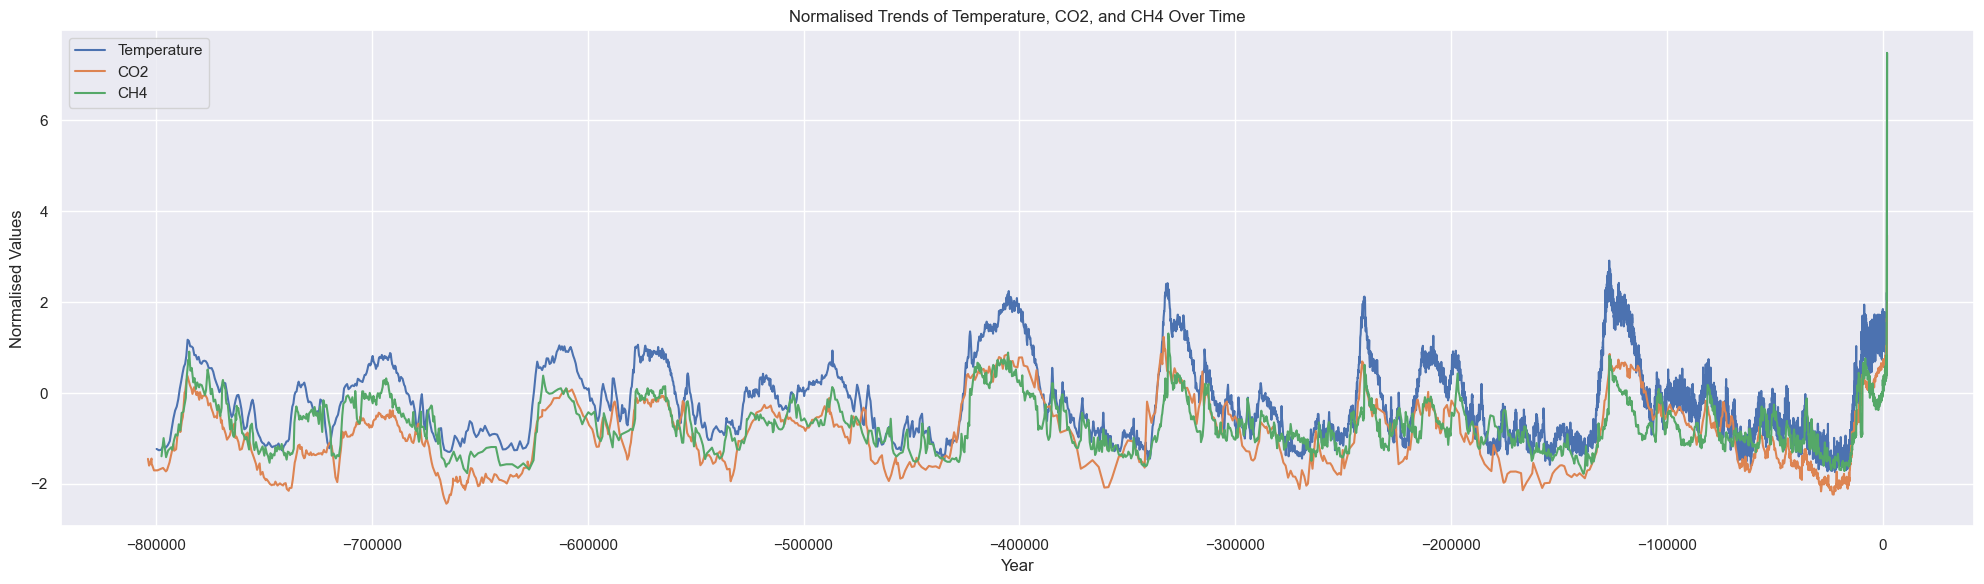

In [12]:
plt.figure(figsize=(20, 6))

# Normalising the data for overlaying
normalised_data = (
    antarctic_df[["temp (°C)", "CO2 (ppmv)", "CH4 (ppbv)"]] - antarctic_df[["temp (°C)", "CO2 (ppmv)", "CH4 (ppbv)"]].mean()) / antarctic_df[["temp (°C)", "CO2 (ppmv)", "CH4 (ppbv)"]].std()

# Overlaying the plots
sns.lineplot(data=normalised_data, x=antarctic_df.index, y="temp (°C)", label="Temperature")
sns.lineplot(data=normalised_data, x=antarctic_df.index, y="CO2 (ppmv)", label="CO2")
sns.lineplot(data=normalised_data, x=antarctic_df.index, y="CH4 (ppbv)", label="CH4")

plt.title("Normalised Trends of Temperature, CO2, and CH4 Over Time")
plt.ylabel("Normalised Values")
plt.xlabel("Year")
plt.legend()
plt.tight_layout();

The plot above displays the normalised trends of temperature, carbon dioxide (CO2), and methane (CH4) over time. Normalisation was performed to bring the different scales of these variables onto a comparable level, allowing for a more meaningful comparison of their trends. It can be seen how the trends in temperature and carbon dioxide align over the years.

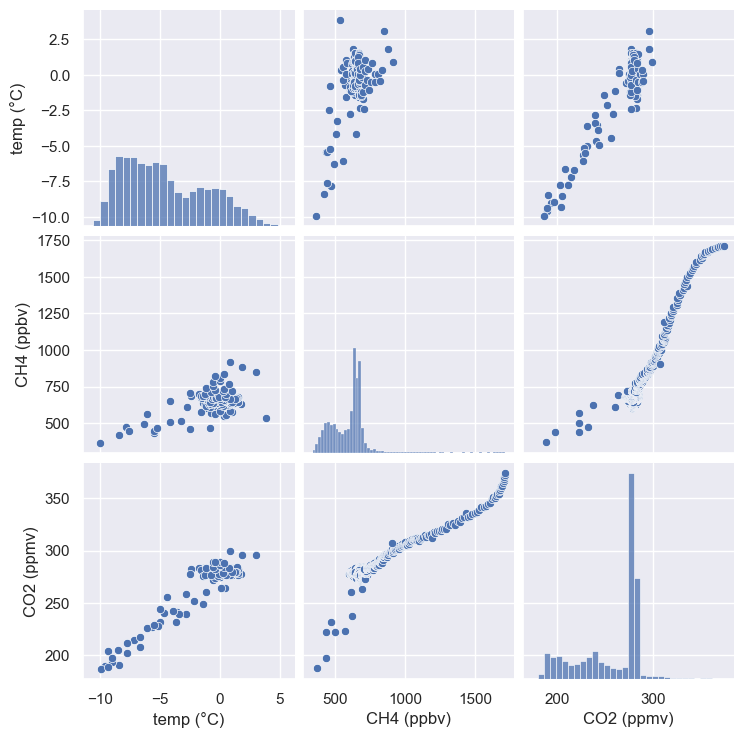

In [13]:
sns.pairplot(antarctic_df);

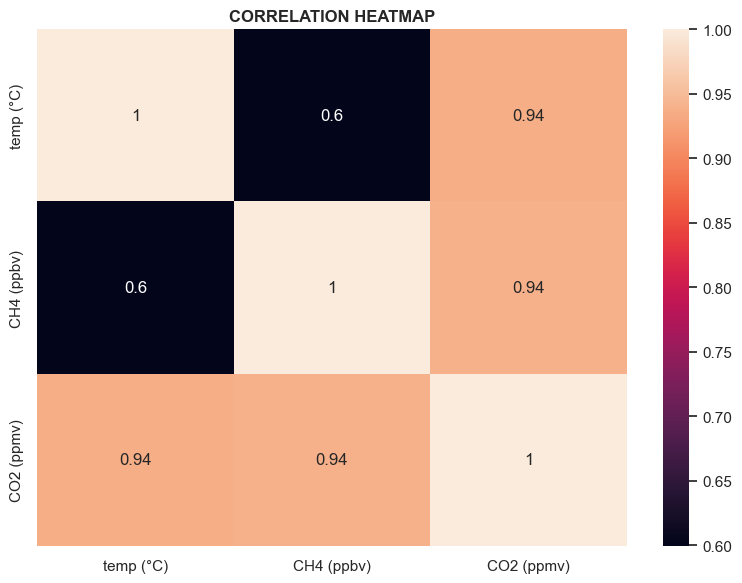

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(antarctic_df.corr(), annot=True)
plt.title("CORRELATION HEATMAP", fontweight="bold")
plt.tight_layout()

The correlation between temperature and the levels of carbon dioxide and methane is extremely strong, with a coefficient of 0.94.

### **Irish Weather Datasets**

Importing, cleaning, and transforming the Irish temperature weather data.

In [15]:
irish_weather_df = pd.read_csv(
    "./data/irish/mly2275.csv",
    sep=",",
    skiprows=19,
    usecols=["year", "month", "meant", "rain"],
)

irish_weather_df['date'] = pd.to_datetime(irish_weather_df[['year', 'month']].assign(DAY=1))
irish_weather_df.rename(columns={"rain": "irish rainfall (mm)"}, inplace=True)
irish_weather_df.set_index('date', inplace=True)
irish_weather_df.drop(columns=['year', 'month'], inplace=True)

In [16]:
# Reading in the csv file
irish_temp_df1 = pd.read_csv(
    "./data/irish/Valentia-Observatory_second-order-station_1883-1909.csv",
    sep=",",
    encoding="ISO-8859-1")

# Transforming the dataset
irish_temp_df1.drop(["Max (°F)", "Min (°F)"], axis=1, inplace=True)
irish_temp_df1["meant"] = irish_temp_df1[["Max (°C)", "Min (°C)"]].mean(axis=1)
irish_temp_df1.drop(["Max (°C)", "Min (°C)"], axis=1, inplace=True)
irish_temp_df1.rename(columns={"Year": "year", "Month": "month", "Day ": "day"}, inplace=True)
irish_temp_df1["date"] = pd.to_datetime(irish_temp_df1[["year", "month", "day"]], errors="coerce")
irish_temp_df1 = irish_temp_df1.drop(["year", "month", "day"], axis=1)

# Reading in the csv file
irish_temp_df2 = pd.read_csv(
    "./data/irish/Valentia-Observatory-telegraphic-reporting-station_1850-1920.csv",
    sep=",",
    encoding="ISO-8859-1")

# Transforming the dataset
irish_temp_df2.drop(["Max (°F)", "Min (°F)"], axis=1, inplace=True)
irish_temp_df2["meant"] = irish_temp_df2[["Max (°C)", "Min (°C)"]].mean(axis=1)
irish_temp_df2.drop(["Max (°C)", "Min (°C)"], axis=1, inplace=True)
irish_temp_df2.rename(columns={"Year": "year", "Month": "month", "Day": "day"}, inplace=True)
irish_temp_df2["date"] = pd.to_datetime(irish_temp_df2[["year", "month", "day"]], errors="coerce")
irish_temp_df2 = irish_temp_df2.drop(["year", "month", "day"], axis=1)

# Reading in the csv file
irish_temp_df3 = pd.read_csv(
    "./data/irish/Valentia-Observatory-telegraphic-reporting-station_1921-1943.csv",
    sep=",",
    encoding="ISO-8859-1")

# Transforming the dataset
irish_temp_df3.drop(["Max at 7h (°F)", "Min at 7h (°F)", "Max at 18h (°F)", "Min at 18h (°F)"],axis=1,inplace=True,)
irish_temp_df3["meant"] = irish_temp_df3[["Max at 7h (°C)", "Min at 7h (°C)", "Max at 18h (°C)", "Min at 18h (°C)"]].mean(axis=1)
irish_temp_df3.drop(["Max at 7h (°C)", "Min at 7h (°C)", "Max at 18h (°C)", "Min at 18h (°C)"], axis=1, inplace=True,)
irish_temp_df3.rename(columns={"Year": "year", "Month": "month", "Daily": "day"}, inplace=True)
irish_temp_df3["date"] = pd.to_datetime(irish_temp_df3[["year", "month", "day"]], errors="coerce")
irish_temp_df3 = irish_temp_df3.drop(["year", "month", "day"], axis=1)

# Combining the datasets
irish_temp_df = pd.concat([irish_temp_df1, irish_temp_df2, irish_temp_df3])
irish_temp_df.set_index('date', inplace=True)

#### **Combined Irish DataFrame**

Transform the datasets into a combined DataFrame.

In [17]:
irish_weather_df  = pd.merge(irish_weather_df, irish_temp_df, left_index=True, right_index=True, how="outer")
irish_weather_df['irish temp (°C)'] = irish_weather_df['meant_x'].combine_first(irish_weather_df['meant_y'])
irish_weather_df.drop(['meant_x', 'meant_y'], axis=1, inplace=True)
irish_weather_df = irish_weather_df[~irish_weather_df.index.duplicated(keep='first')]
irish_weather_df = irish_weather_df.dropna(subset=["irish temp (°C)", "irish rainfall (mm)"], how="all")
irish_weather_df['month'] = irish_weather_df.index.month
irish_weather_df['year'] = irish_weather_df.index.year
irish_weather_df

,irish rainfall (mm),irish temp (°C),month,year
date,,,,
1850-10-19,NaN,14.4,10,1850
1850-10-20,NaN,13.1,10,1850
1850-10-21,NaN,10.5,10,1850
1850-10-22,NaN,7.5,10,1850
1850-10-23,NaN,10.2,10,1850
...,...,...,...,...
2023-07-01,170.3,15.3,7,2023
2023-08-01,177.1,15.9,8,2023
2023-09-01,189.3,15.6,9,2023


### **Plotting the Irish DataFrame**

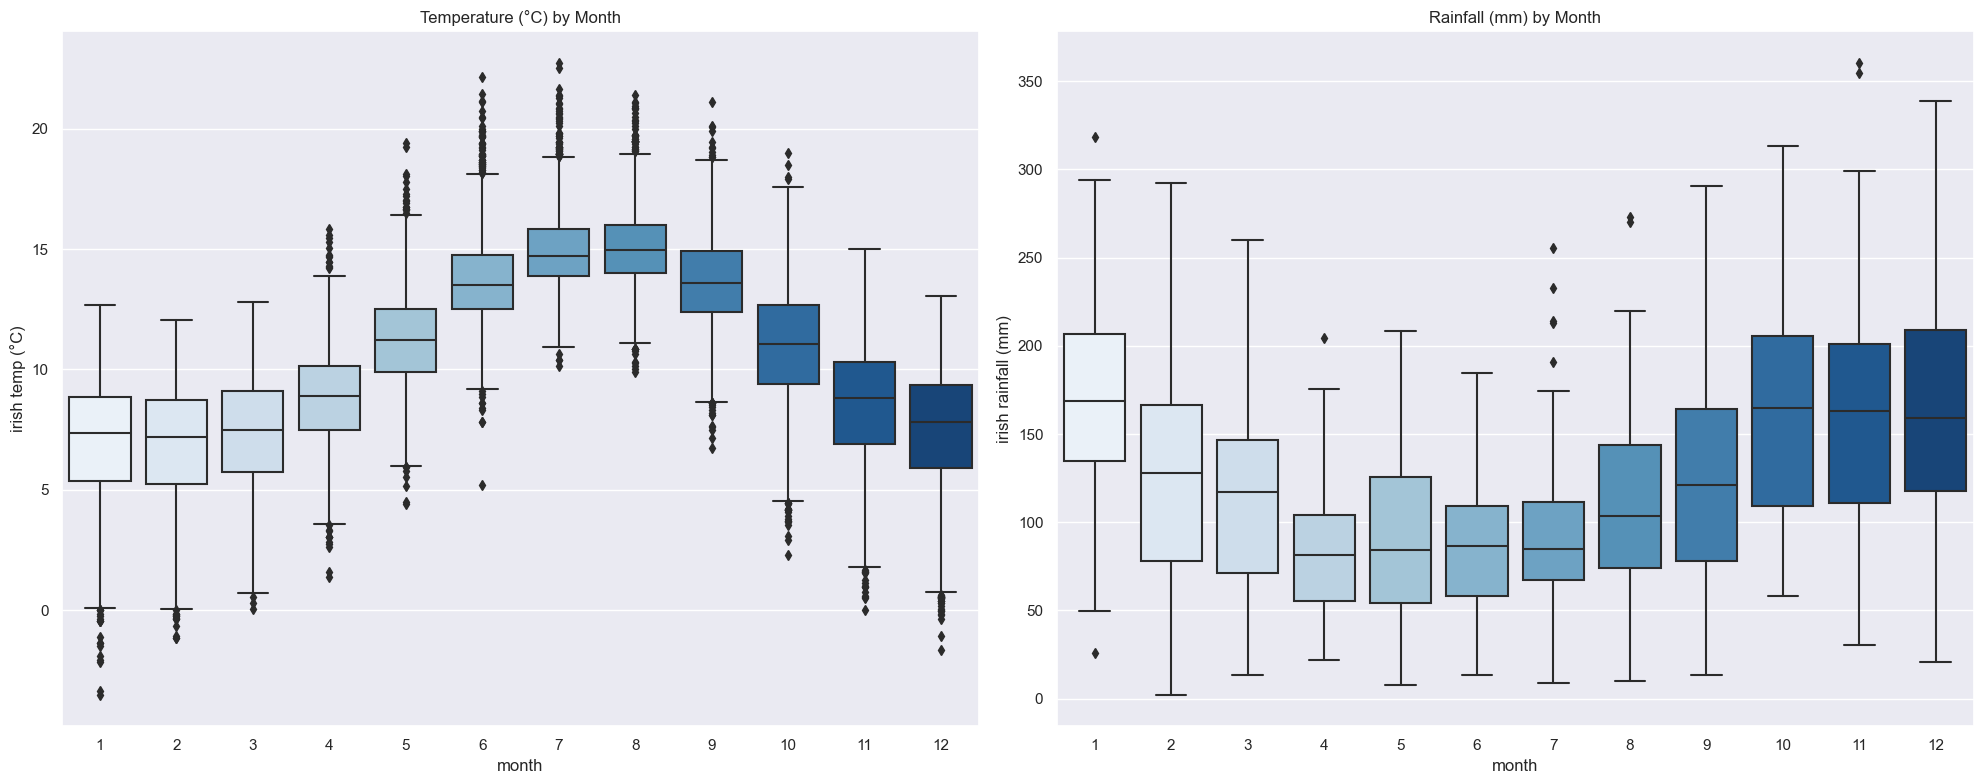

In [19]:
plt.figure(figsize=(20, 8))

# Irish Temperature
ax1 = plt.subplot(1, 2, 1)
sns.boxplot(data=irish_weather_df, x='month', y='irish temp (°C)', palette='Blues')
ax1.set_title('Temperature (°C) by Month')

# Irish Rainfall
ax2 = plt.subplot(1, 2, 2)
sns.boxplot(data=irish_weather_df, x='month', y='irish rainfall (mm)', palette='Blues')
ax2.set_title('Rainfall (mm) by Month')
plt.tight_layout()

#### **Composite Weather DataFrame**

In [20]:
irish_weather_df = irish_weather_df.drop(["month"], axis=1)
irish_weather_df = irish_weather_df.groupby("year").mean()

In [21]:
df  = pd.merge(antarctic_df, irish_weather_df, left_index=True, right_index=True, how="outer")
df

,temp (°C),CH4 (ppbv),CO2 (ppmv),irish rainfall (mm),irish temp (°C)
year,,,,,
-803718,NaN,NaN,207.285440,NaN,NaN
-803182,NaN,NaN,202.226839,NaN,NaN
-802572,NaN,NaN,204.861938,NaN,NaN
-802059,NaN,NaN,207.498645,NaN,NaN
-801975,NaN,NaN,202.921723,NaN,NaN
...,...,...,...,...,...
2019,NaN,NaN,NaN,141.800000,11.125000
2020,NaN,NaN,NaN,161.791667,10.991667
2021,NaN,NaN,NaN,129.025000,11.141667


Export to csv and json formats.

In [23]:
df.to_csv('./export/weather.csv')
df.to_json('./export/weather.json')

#### **Composite Weather DataFrame**

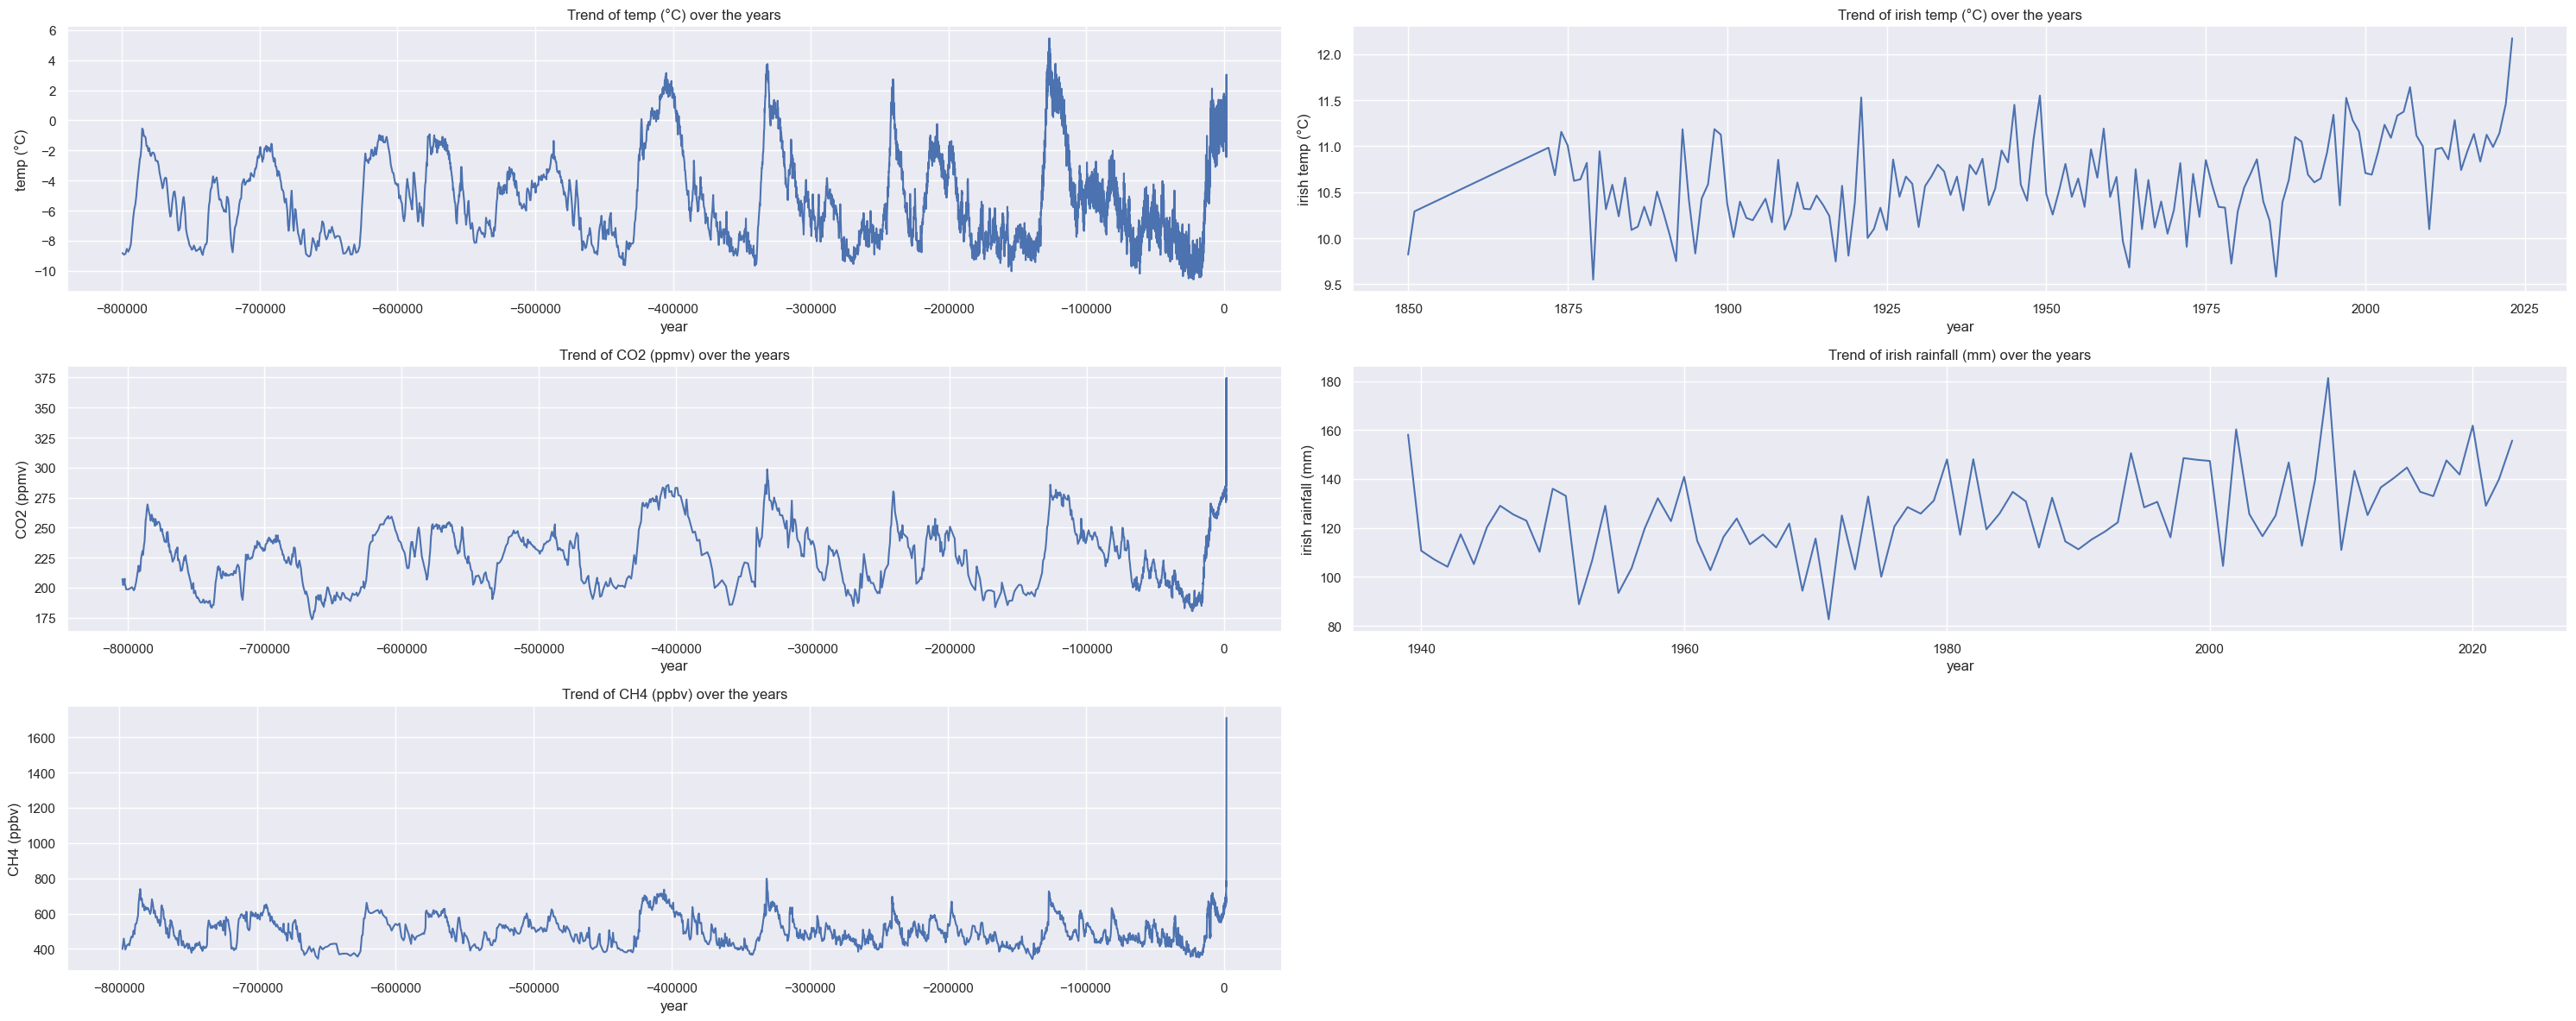

In [54]:
plt.figure(figsize=(30, 12))

variables = ['temp (°C)', 'irish temp (°C)', 'CO2 (ppmv)', 'irish rainfall (mm)', 'CH4 (ppbv)']

for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.lineplot(x='year', y=var, data=df)
    plt.title(f'Trend of {var} over the years')
    plt.tight_layout()

### **Lead-Lag Correlation Analysis**

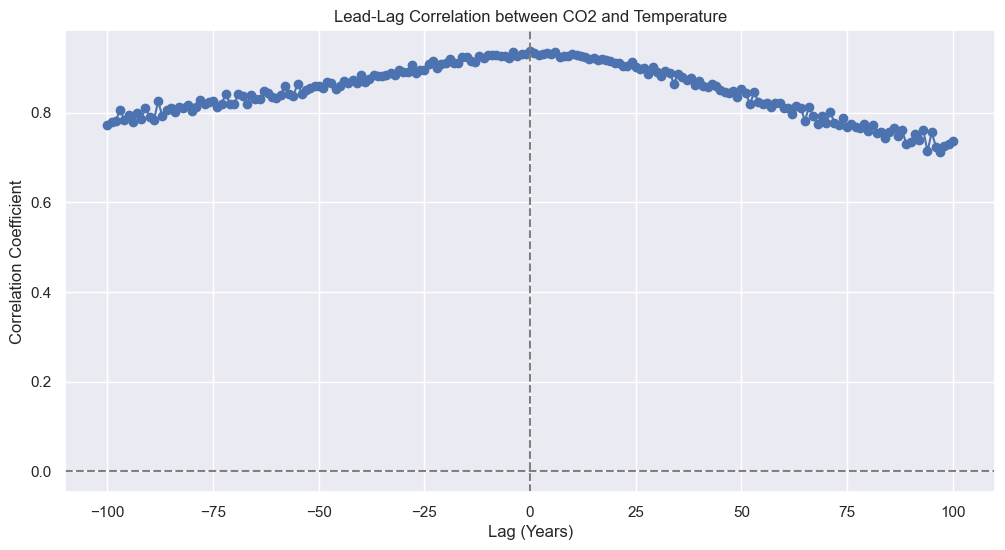

In [64]:
correlation_matrix = df.corr()

lead_lag_steps = range(-100, 101)  # A range of 200 years before and after
lead_lag_correlations = []

for step in lead_lag_steps:
    shifted_df = df[['temp (°C)', 'CO2 (ppmv)']].copy()
    shifted_df['CO2 (ppmv)'] = shifted_df['CO2 (ppmv)'].shift(step)
    corr = shifted_df.corr().iloc[0, 1]
    lead_lag_correlations.append(corr)

plt.figure(figsize=(12, 6))
plt.plot(lead_lag_steps, lead_lag_correlations, marker='o')
plt.title('Lead-Lag Correlation between CO2 and Temperature')
plt.xlabel('Lag (Years)')
plt.ylabel('Correlation Coefficient')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axvline(x=0, color='gray', linestyle='--')
plt.grid(True)

The plot illustrates the correlation between CO2 and temperature at different leads/lags (years). The correlation peaks when CO2 is aligned with the temperature (lag = 0), indicating that changes in CO2 levels are closely aligned with changes in temperature without a significant lead or lag in this dataset.

### **Predict Future Global Temperatures**

Text Analysis

https://guides.library.upenn.edu/penntdm/python/import_files#:~:text=Importing%20Files%20(Web%20Scraping)&text=The%20get()%20function%20in,it%20in%20a%20Python%20object.

Parsing a text file into a pandas DataFrame

https://codereview.stackexchange.com/questions/257729/parsing-a-text-file-into-a-pandas-

Pandas Timestamp Limitations

https://calmcode.io/til/pandas-timerange.html#:~:text=Since%20pandas%20represents%20timestamps%20in,limited%20to%20approximately%20584%20years.

How To Resample and Interpolate Your Time Series Data With Python

https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

pandas.read_excel

https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html


Compilation of improved CH4 data derived from the European Project for Ice Coring in Antarctica (EPICA) Dome C

https://doi.pangaea.de/10.1594/PANGAEA.914908


An optimized multi-proxy, multi-site Antarctic ice and gas orbital chronology (AICC2012): 120–800 ka

https://cp.copernicus.org/articles/9/1715/2013/


How to concatenate multiple column values into a single column in Pandas dataframe

https://stackoverflow.com/questions/39291499/how-to-concatenate-multiple-column-values-into-a-single-column-in-pandas-datafra

pandas.DataFrame.merge

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html

Historic greenhouse gas concentrations from Antarctic ice core sampling

https://www.ansto.gov.au/historic-greenhouse-gases

Normalization Formula: How To Use It on a Data Set

https://machinelearningmastery.com/normalize-standardize-time-series-data-python/

EPICA Dome C Ice Core 800KYr Methane Data

https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-ch4-2008.txt

What is the lead-lag effect, and how is it used in statistics?

https://machinehack.com/story/what-is-the-lead-lag-effect-and-how-is-it-used-in-statistics

How to Use Lagged Time-Series Variables in a Python Pandas Regression Model?

https://stackoverflow.com/questions/39840890/how-to-use-lagged-time-series-variables-in-a-python-pandas-regression-model

Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption

https://www.youtube.com/watch?v=vV12dGe_Fho

Time Series Forecasting with XGBoost - Advanced Methods

https://www.youtube.com/watch?v=z3ZnOW-S550

***
# End